# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [2]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils

importlib.reload(utils)

<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

In [2]:
print(np.zeros(3).reshape(3).shape)

(3,)


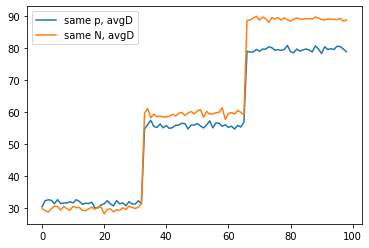

In [17]:
plt.figure()
ss = []
dd = []

each_num = 33
for i in list(range(80, 80+2*60+1, 60)):
    # NOTE: class1 N = 80, p=0.4, avgD = 30, 
    # NOTE: class2 N = 140, p=0.4, avgD = 50,
    # NOTE: class3 N = 200, p=0.4, avgD = 80, 
    for _ in range(each_num):
        g = nx.erdos_renyi_graph(i, 0.4)
        stats = graph_stats_degree(adj=nx.to_numpy_array(g))
        ss.append(stats)

for i in list(np.arange(0.3, 1, 0.3)):
    # NOTE: class1 N = 100, p=0.3, avgD = 30,
    # NOTE: class2 N = 100, p=0.6, avgD = 50,
    # NOTE: class3 N = 100, p=0.9, avgD = 80, 
    for _ in range(each_num):
        g = nx.erdos_renyi_graph(100, i)
        stats = graph_stats_degree(adj=nx.to_numpy_array(g))
        dd.append(stats)
    
ss = np.stack(ss, axis=0)
dd = np.stack(dd, axis=0)
plt.plot(ss[:, 0],label='same p, avgD')
plt.plot(dd[:, 0],label='same N, avgD')
# plt.plot(ss[:, 2], label='totalD')
plt.legend()
plt.show()


In [4]:
a = torch.ones(size=(1, 1))
print(torch.stack([a, a], dim=1).reshape(2).shape)


a = np.array([57.89,
83.33,
73.68,
84.21,
84.21,
73.68,
85.96,
85.96,
84.21,
83.33])


a = np.array([73.684,79.629,85.964,84.210,82.456,78.947,71.929,80.701,80.701,70.370])
a = np.array([68.75,71.471,71.726,66.36,69.669,67.567,72.072,75.375,70.27,71.471])

print(a.mean(), a.std())

torch.Size([2])
70.4731 2.4324140457578367


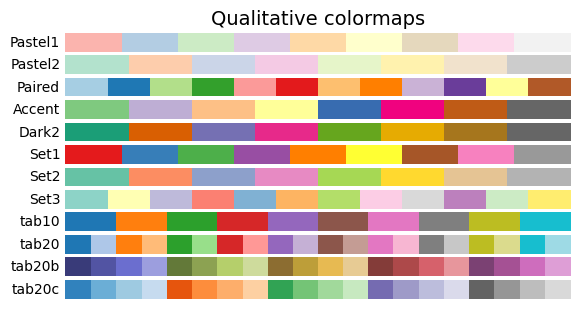

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


# here..
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


x_y_label_font = 20
x_y_legend_font = 20

plt.rc('font', family='Times New Roman')
fig_dpi = 220
fig_shape_squre = (6, 5)

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh), dpi=100)
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    plt.show()

class MyColor(object):
    def __init__(self, cmap_name='tab10', skip_idx=5, backup_name='Set1', backup_color=3):
        self.color_set  = plt.get_cmap(cmap_name).colors
        self.backup_set = plt.get_cmap(backup_name).colors
        self.backup_color = backup_color
        self.skip_idx=skip_idx
        self.idx = 0
        self.color_len = len(self.color_set)
        
    def get_color(self):
        if self.idx == self.color_len - 1:
            self.idx = 0
        if self.idx == self.skip_idx:
            self.idx += 1
            return self.backup_set[self.backup_color]
        color = self.color_set[self.idx]
        self.idx += 1
        return color
    

plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

# TODO: 0918. For all benchmark datasets.
* check the correlation between degree and CC 
* or $|C_k|$, $k>3$
* Why related to training difficulty? because that GNN cannot learn them.
* Why cannot learn? computational graphs are the same and is bounded by k-WL-test.
* So requires additional information of subgraphs, but $O(kN)$ complexity.
* so sampling may be a good choice.
* may use DP to sample.

* based on above figure, pick same horizontal points
- blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
- redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

# Generate WS graph node feature

# construct node clustring coefficient label

# Generate WS graph dataloader

# CCA (Canical Component Analysis)

# Check whether GNN can learn the CC ?

# generate CC historgram with same degree
# cc without degree correlation bias



# load OGB dataset:

In [4]:
from matplotlib import ticker
import numpy as np
from matplotlib.pyplot import MultipleLocator


x_y_label_font = 10
x_y_legend_font = 10


def plot_bars(X, y, y_err=None, legend_pos=None, label="None", ax=None, colors=None, width=0.1):
    color = 'black'
    err_attr={"elinewidth":2,"ecolor":"black","capsize":6}
    if colors is None:
         colors = ['#F9DA4A','#96DB35', '#66C2A5','#81B0D3','#EF8C61']
         
    # ax.bar(X, y, yerr=y_err, error_kw=err_attr, color = colors,
    #         width=width, label=label)
    ax.bar(X, y, color = colors,
             width=width, tick_label=label)
    
    ax.set_ylabel('Correlation', color=color, fontsize=x_y_label_font)
    
     # fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=color, labelsize=x_y_label_font)
    ax.tick_params(axis='x', rotation=70, labelsize=x_y_label_font)
    # plt.xticks(rotation=180)
    
    # ax.tick_params(axis='x)
    # ax.legend([logit.m1], prop={'size': 15}, labelspacing=0.1)
#     ax.set_title(label, fontsize=x_y_label_font)
    # plt.rcParams['xtick.direction'] = 'in'



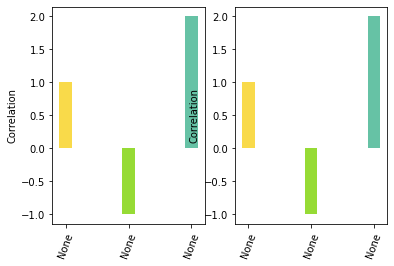

In [30]:
# test bar:
xxx = np.linspace(0, 1, num=3)
fig, axess = plt.subplots(1, 2)

plot_bars(xxx, [1,-1,2], ax=axess[0])
plot_bars(xxx, [1,-1,2], ax=axess[1])
plt.show()



In [33]:
import my_utils as utils
importlib.reload(utils)

import networkx as nx
from functools import reduce
import models
importlib.reload(models)


def graphs_statistics(adjs:list, labels:list):
    
    statistics = []
    for i, A in enumerate(adjs):
        nx_g = nx.from_numpy_array(A)
        avg_cc = nx.average_clustering(nx_g)
        avg_degree = np.mean(node_feature_utils.node_degree_feature(adj=A)).item()
        tris = np.mean(node_feature_utils.node_tri_cycles_feature(adj=A)).item()
        cycles = nx.cycle_basis(nx_g)
        N = A.shape[0]
        statistics.append((N, avg_cc, avg_degree, tris, cycles, labels[i]))
    
    return statistics


def plot_cyc_degree_corr(title:str, statistics_sorted:list, data_labels:tuple, axe=None, 
                           sort_idx=None, show_idx:list=None, anchor:int=None,corrs_type='MIC'):
    # NOTE: Sorted by other index
    if sort_idx is not None:
        statistics_sorted = sorted(statistics_sorted, key=lambda x: x[sort_idx])
        
    # TODO: Filter cycles and degree outliers, abs(z-score) > 3.
    statistics_sorted_filtered = []
    for i in statistics_sorted:
        # NOTE: filter any outliers:
        need_filter = False
        for l in range(len(i)):
            if i[l] < -3 or i[l] > 3 or i[l] < -3 or i[l] > 3:
                need_filter = True
                break
            
        if need_filter:
            continue
        
        statistics_sorted_filtered.append(i)
    
    statistics_sorted = statistics_sorted_filtered
    # TODO: Get correlation:
    corrs = utils.get_corrs(statistics_sorted, cate='all')

    axe.set_title(title)
    
    if show_idx is None:
        show_idx = list(range(len(statistics_sorted[0])))
        
    X = np.linspace(0, 1, len(show_idx))
    y = np.array([np.abs(corrs[corrs_type][id, anchor]) for id in show_idx])
    color = MyColor('Accent', skip_idx=3, backup_name='Set1', backup_color=7)
    colors = [color.get_color() for _ in show_idx]
    legends = [data_labels[i] for i in show_idx]
    plot_bars(X, y,label=legends, ax=axe, colors=colors)
    
    
def plot_graphs_statistics(title:str, statistics_sorted:list, data_labels:tuple, axe=None, 
                           sort_idx=None, show_idx:list=None, plot_corr_bar=False):
    from matplotlib import lines
    line_styles = list(lines.lineStyles.keys())
    def get_style(next_id):
        return line_styles[next_id%len(line_styles)]
    
    colors = MyColor()
    
    
    # NOTE: Sorted by other index
    if sort_idx is not None:
        statistics_sorted = sorted(statistics_sorted, key=lambda x: x[sort_idx])
        
    # TODO: Filter cycles and degree outliers, abs(z-score) > 3.
    statistics_sorted_filtered = []
    for i in statistics_sorted:
        # NOTE: filter any outliers:
        need_filter = False
        for l in range(len(i)):
            if i[l] < -3 or i[l] > 3 or i[l] < -3 or i[l] > 3:
                need_filter = True
                break
        if need_filter:
            continue
        
        statistics_sorted_filtered.append(i)
    
    statistics_sorted = statistics_sorted_filtered
    # TODO: Get correlation:
    corrs = utils.get_corrs(statistics_sorted, cate='all')
    
    if plot_corr_bar:
        axe.set_title(title)
        axe.plot_bar
    
    
    
    if axe is not None:
        MIC_corr = f"M(dc)={round(corrs['MIC'][1, -2], 2)}, M(dy)={round(corrs['MIC'][1, -1], 2)}," \
                     + f" M(cy)={round(corrs['MIC'][-2, -1], 2)}"
        axe.set_title(title+f"\n C(dc)={round(corrs['pearson'][1, -2], 2)}, C(dy)={round(corrs['pearson'][1, -1], 2)}," \
                     + f" C(cy)={round(corrs['pearson'][-2, -1], 2)}\n{MIC_corr}")
        # NOTE: C: correlation, d:degree, c: cycles, y:labels of samples.
        
        
        if show_idx is None:
            show_idx = list(range(len(statistics_sorted[0])))
        
        
        for sid in show_idx:
            # TODO: color?
            axe.plot([i[sid] for i in statistics_sorted], label=data_labels[sid], 
                     linestyle=get_style(sid), color=colors.get_color())
            
    else:
        plt.figure()
        plt.title(title)
        if show_idx is None:
            show_idx = list(range(len(statistics_sorted[0])))
            
        print('avgD/N', statistics_sorted[0][4])
        for id in show_idx:
            plt.plot([i[id] for i in statistics_sorted], label=data_labels[id], color=colors.get_color())
        
        plt.legend()
        plt.show()


def plot_cc_degree_distribution(cc_degree_graphs, cc_degree_y, g_label='train'):
    
    # random add edges:
    # add E edges, repeat for 5 times.
    print(type(cc_degree_graphs[0].todense()))

    data_graphs = [(cc_degree_y[i],np.mean(np.sum(cc_degree_graphs[i].todense(), axis=1)), np.mean(node_feature_utils.node_tri_cycles_feature(adj=cc_degree_graphs[i])).item(), i) for i in range(len(cc_degree_graphs))]

    data_graphs_s_train = sorted(data_graphs, key=lambda x: x[0])

    ccs = [d[0] for d in data_graphs_s_train]
    degrees = [d[1]/10 for d in data_graphs_s_train]
    tri_cycles = [d[2]/4 for d in data_graphs_s_train]

    plt.figure()
    plt.title(g_label)
    plt.plot(ccs, label='labels')
    plt.plot(degrees, label='degree',  linestyle='--')
    plt.plot(tri_cycles, label='tri_cycles', linestyle='-.')
    plt.legend()
    plt.show()
    
    

# Try Real-world dataset from PyG generic datasets
website: `https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html`

* graph classification:
    * TUDataset
    * ZINC

## TODO: 
1. use. # due: 6.30.
2. profile. # due: 7.1.

## TODO (2022.09.24):
* 1. load from gnn-comparison module.
* 2. check the avg.CC avg.Degree and performance associations.

In [6]:
import sys,os
sys.path.append(os.getcwd())

from gnn_comparison.PrepareDatasets import DATASETS

print(DATASETS.keys())

datasets_obj = {}
for k, v in DATASETS.items():
    print('dataset name:', k)
    dat = v()
    datasets_obj[k] = dat
    print(type(dat.dataset.get_data()))


dict_keys(['COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL'])
dataset name: COLLAB
processed_dir:  DATA/COLLAB/processed
5000
<class 'list'>
dataset name: IMDB-BINARY
processed_dir:  DATA/IMDB-BINARY/processed
1000
<class 'list'>
dataset name: IMDB-MULTI
processed_dir:  DATA/IMDB-MULTI/processed
1500
<class 'list'>
dataset name: NCI1
processed_dir:  DATA/NCI1/processed
4110
<class 'list'>
dataset name: ENZYMES
processed_dir:  DATA/ENZYMES/processed
600
<class 'list'>
dataset name: PROTEINS
processed_dir:  DATA/PROTEINS_full/processed
1113
<class 'list'>
dataset name: DD
processed_dir:  DATA/DD/processed
1178
<class 'list'>
dataset name: MUTAG
processed_dir:  DATA/MUTAG/processed
188
<class 'list'>
dataset name: CSL
processed_dir:  DATA/CSL/processed
600
<class 'list'>


In [7]:
import gnn_comparison
importlib.reload(gnn_comparison)
import gnn_comparison.PrepareDatasets as predata
importlib.reload(predata)

def add_obj(name):
    cls = predata.DATASETS[name]
    dat = cls()
    datasets_obj[name] = dat
    
# add_obj('COLLAB')
# add_obj('NCI1')


In [14]:

def get_pyg_dataset_stats(pyg_data):
    adjs = []
    # TODO: transform into networkx.
    labels = []
    for graph in pyg_data.dataset.get_data():
        row = graph.edge_index[0]
        col = graph.edge_index[1]
        graph.y
        N = graph.x.shape[0]
        dense_A = torch.zeros((N, N))
        dense_A[row, col] = 1
        A = dense_A.detach().numpy()
        adjs.append(A)
        labels.append(graph.y.item())
    return graphs_statistics(adjs, labels)


# print(node_feature_utils.node_cc_avg_feature(adj=dense_A.detach().numpy()))

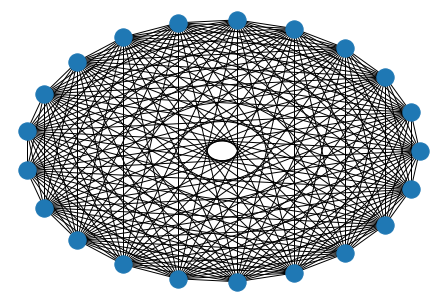

In [9]:
# TODO: show ego network in IMDB-B


adj = datasets_obj['IMDB-BINARY'].dataset.get_data()[555].to_numpy_array()
# meaningless.
# all are complete graph.
g = nx.from_numpy_array(adj)
nx.draw_circular(g)

In [15]:
# TODO: plot on one figure:
datasets_stats = {}
for k, v in datasets_obj.items():
    datasets_stats[k] = get_pyg_dataset_stats(v)

KeyboardInterrupt: 

In [16]:
datasets_stats = {}
datasets_stats['IMDB-BINARY'] = get_pyg_dataset_stats(datasets_obj['IMDB-BINARY'])

In [35]:
importlib.reload(utils)
import pandas as pd

data_stats = {}
K = 11
tuple_label = ['TotalD','N', 'AvgCC', 'AvgD', 'AvgD/N', 'tris']
[tuple_label.append(f'cyc={k}') for k in range(3, K)]
tuple_label.append('y')


print('tuple_label:', tuple_label)

normed_stats = {}
for name, st in datasets_stats.items():
    print(f'dataset {name}, len: {len(st)}')
    stats_tuples = []
    
    for i in range(len(st)):
        Ns = st[i][0]
        cc = st[i][1]
        degree = st[i][2]
        tris= st[i][3]
        y = st[i][-1]
        cycles = st[i][-2]
        total_degree = Ns * degree
        avgDN = degree/Ns
        
        counter_cur = defaultdict(int)
        for c in cycles:
            if len(c) < K:
                counter_cur[len(c)] += 1
        cycle_num = [0]
        for k in range(3, K):
            if k in counter_cur:
                cycle_num.append(counter_cur[k])
            else:
                cycle_num.append(0)
                
        cycle_num.pop(0)
        cycle_num = tuple(cycle_num)
        
        stats_tuples.append((total_degree, Ns, cc, degree, avgDN, tris, *cycle_num, y))
    
    data_array = pd.DataFrame(stats_tuples).values
    # TODO: normalize:
    # data_array = utils.normalize(data_array, along_axis=-1, ignore_norm=[])
    
    normed_stats[name] = data_array
    

tuple_label: ['TotalD', 'N', 'AvgCC', 'AvgD', 'AvgD/N', 'tris', 'cyc=3', 'cyc=4', 'cyc=5', 'cyc=6', 'cyc=7', 'cyc=8', 'cyc=9', 'cyc=10', 'y']
dataset IMDB-BINARY, len: 1000


[[1, 9, 6, 3, 0], [8, 9, 6, 3, 0], [10, 9, 6, 3, 0], [4, 7, 6, 3], [8, 7, 6, 3, 0], [10, 7, 6, 3, 0], [2, 5, 6, 3], [4, 5, 6, 3], [8, 5, 6, 3, 0], [1, 4, 3, 0], [1, 2, 3, 0], [10, 2, 3, 0]]
[[3.]
 [2.]
 [3.]
 [6.]
 [3.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [1.]]


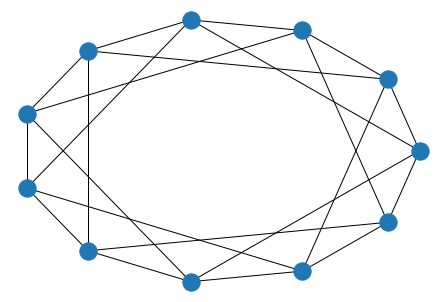

In [18]:
# NOTE: for testing:

test_g = nx.circulant_graph(11, [1, 3])
nx.draw_circular(test_g)

cycles = nx.cycle_basis(test_g)
# collect all len 4 sets.
node_fea = np.zeros((11, 1))
k=4
print(cycles)
# nodes = 
for c in cycles:
    if len(c) == k:
        for id in c:
            node_fea[id] += 1
print(node_fea)

nrows: 1 total 1


TypeError: 'AxesSubplot' object does not support indexing

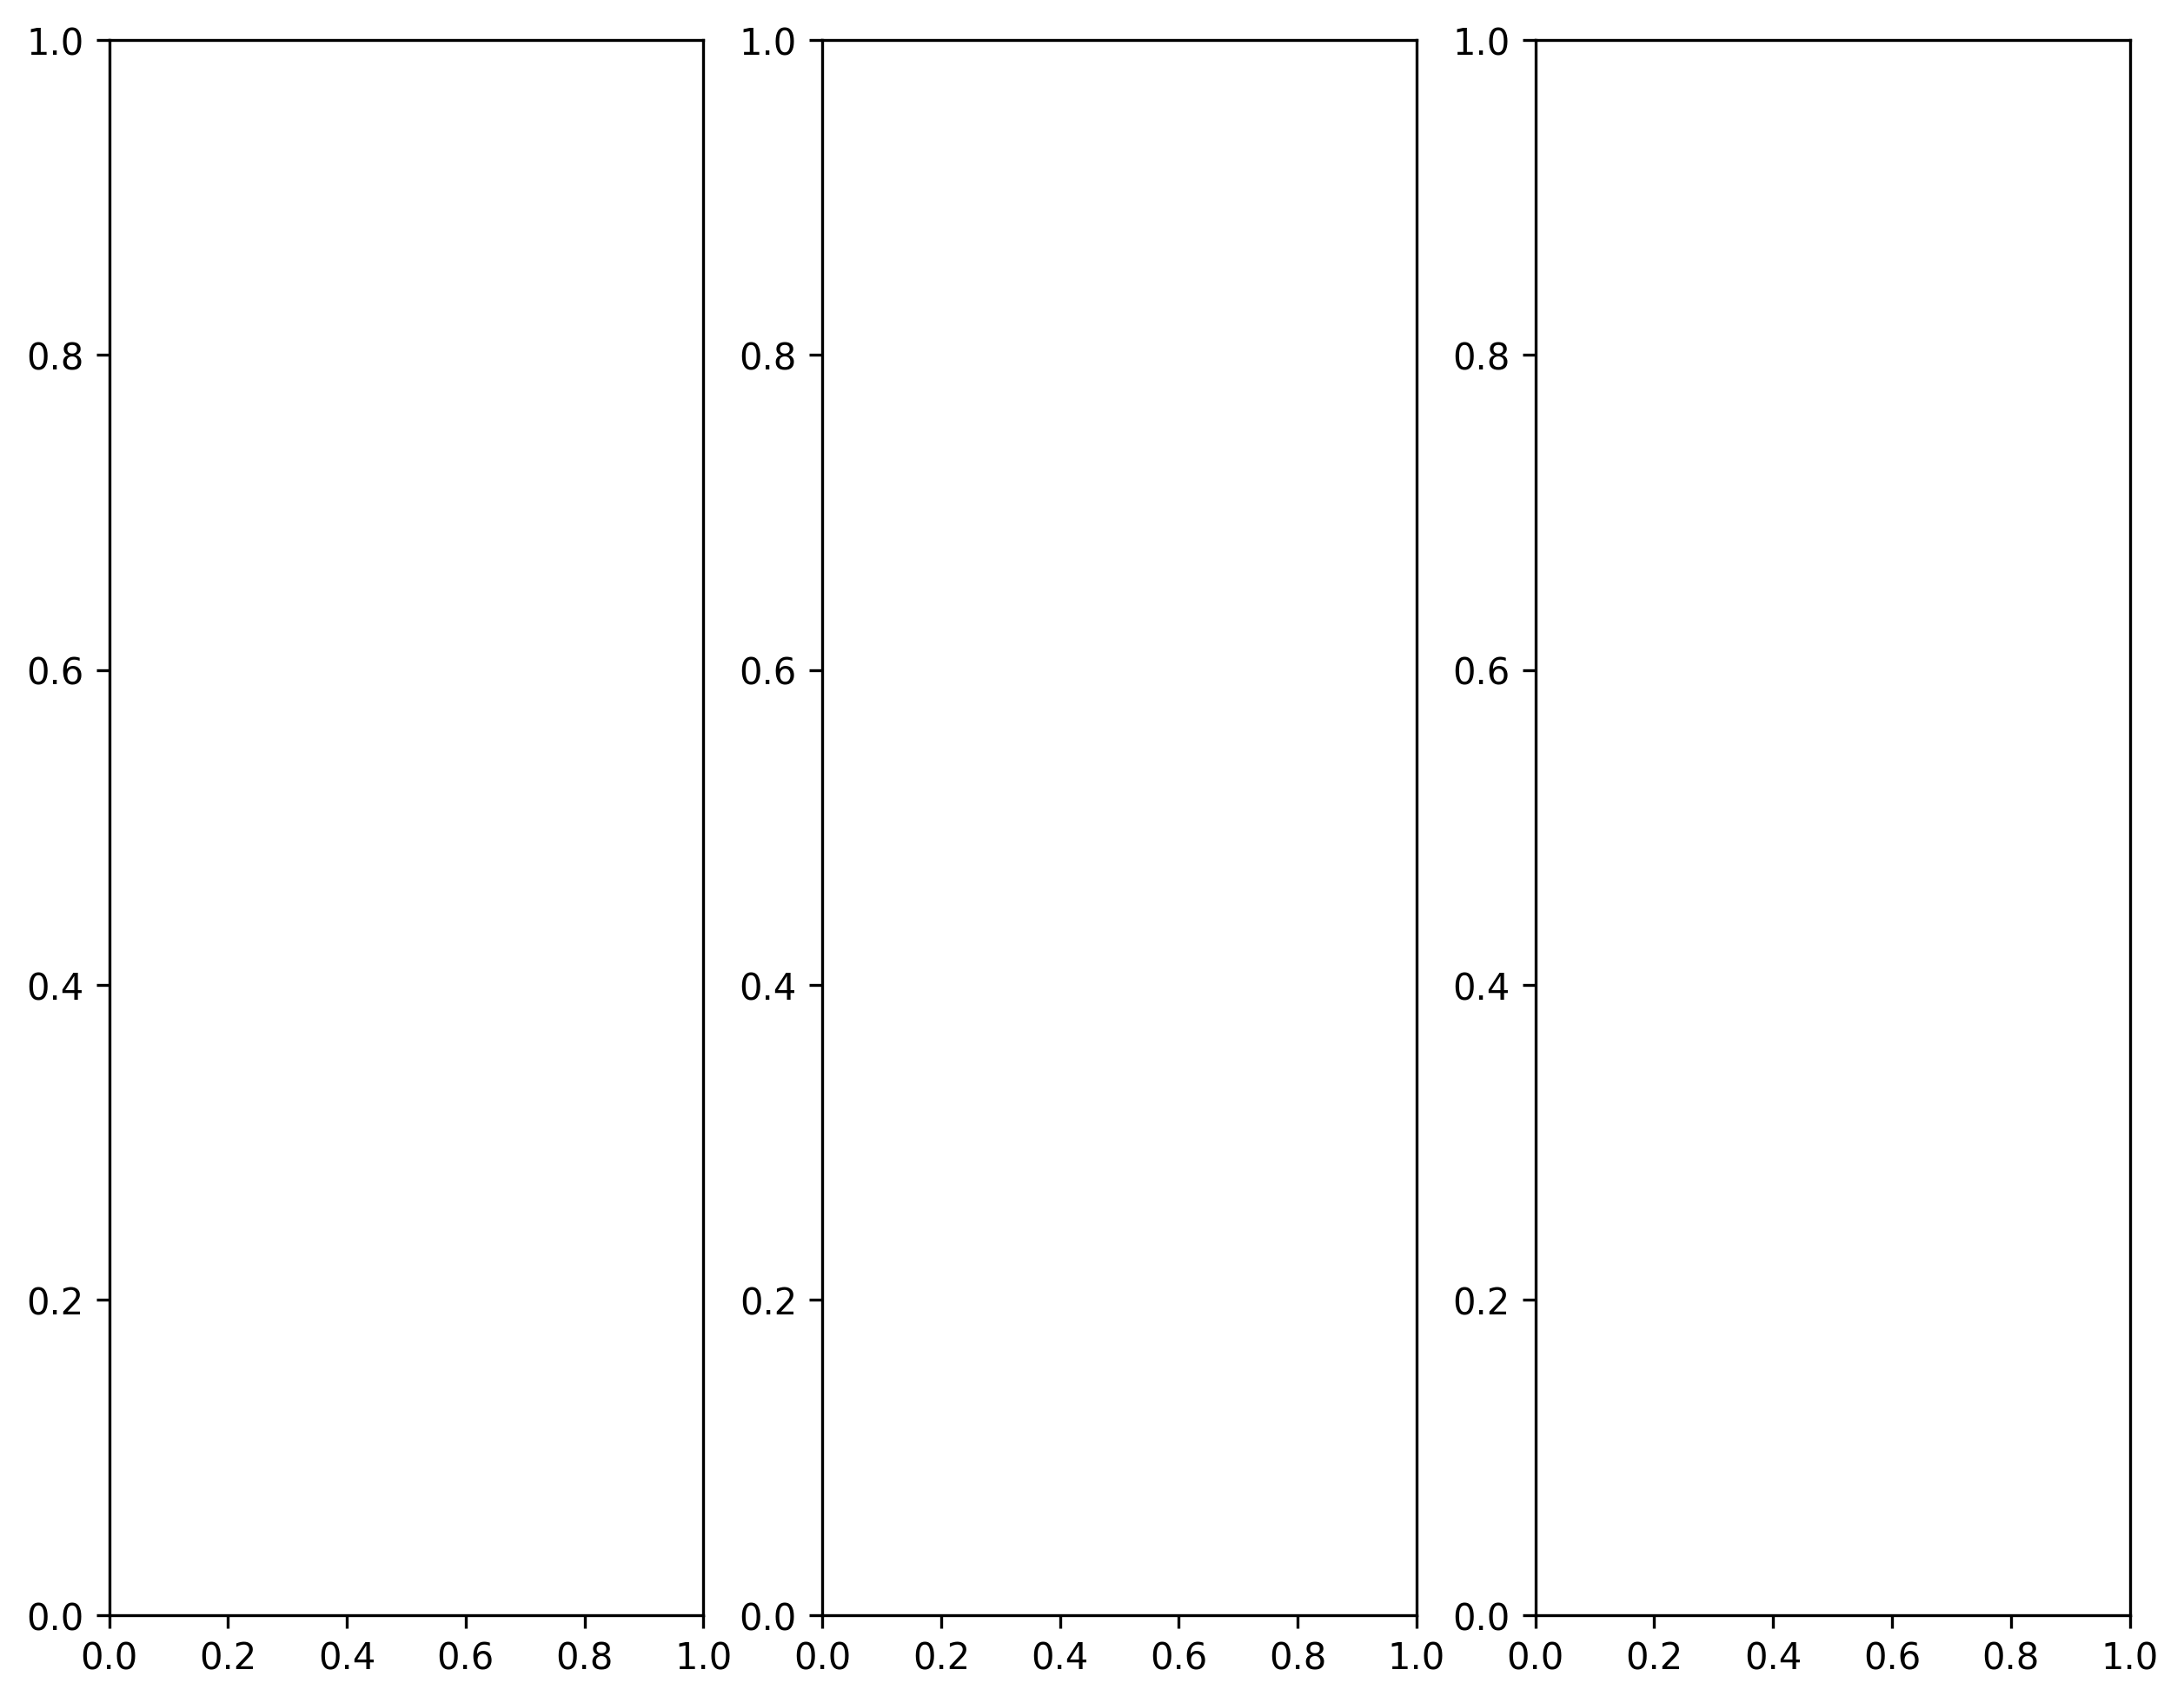

In [18]:
# TODO: def histogram


def plot_histogram(data_states=None):

    # Fixing random state for reproducibility

    # mu, sigma = 100, 15
    # x = mu + sigma * np.random.randn(10000)

    # the histogram of the data
    
    # n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
    
    total = len(data_states.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    
    for idx, (name, normed_stat) in enumerate(data_states.items()):
        axe = axes[int(idx/3)][idx%3]
        axe.hist(normed_stat[:,0], 100, density=False, facecolor='g', alpha=0.75)
        axe.set_title(name)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    plt.tight_layout()
    plt.show()
    
    
    
    
plot_histogram(normed_stats)

In [19]:
def plot_stats(cur_data_stats:dict, show_idx=None):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_graphs_statistics(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    plt.tight_layout()
    plt.show()

nrows: 1 total 1


TypeError: 'AxesSubplot' object does not support indexing

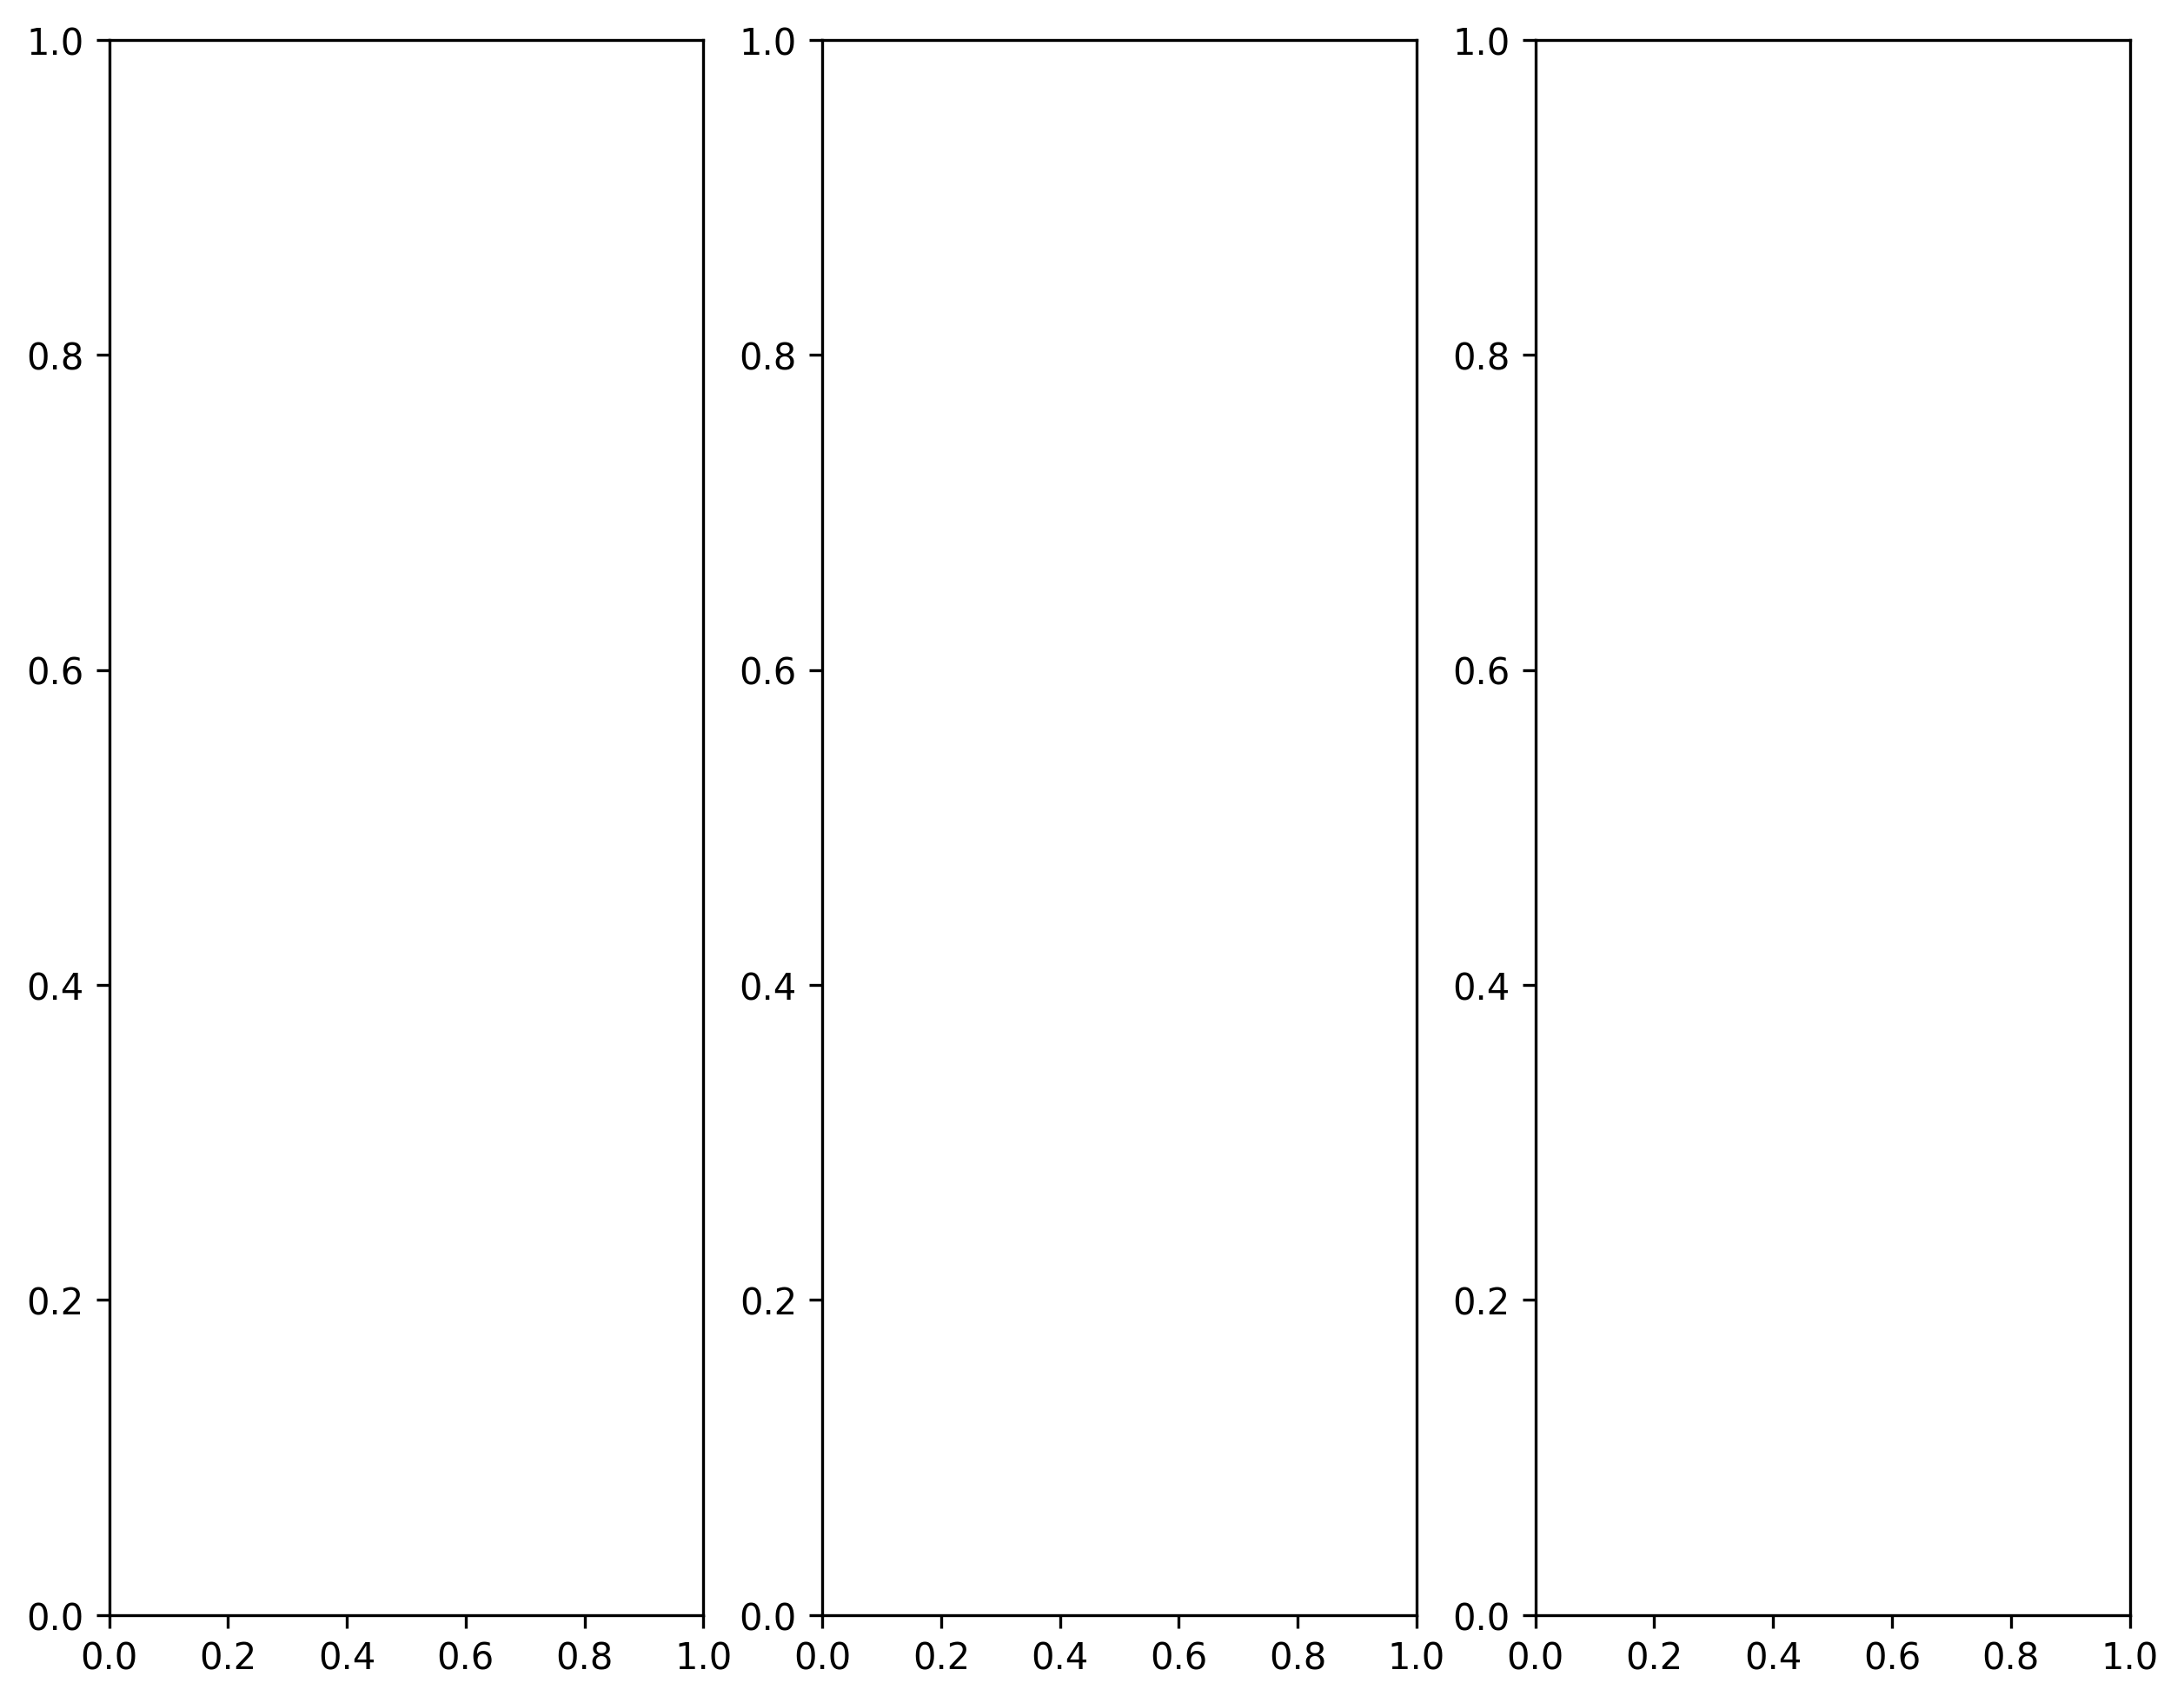

In [20]:
importlib.reload(utils)

# ['TotalD', 'N', 'AvgCC', 'AvgD', 'AvgD/N', 'tris', 'cyc=3', 'cyc=4',
#  'cyc=5', 'cyc=6', 'cyc=7', 'cyc=8', 'cyc=9', 'cyc=10', 'y']



plot_stats(normed_stats, show_idx=[1, 3, 4])

IndexError: list index out of range

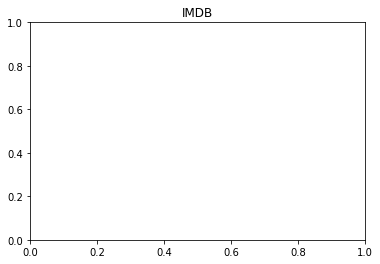

In [36]:
plot_graphs_statistics('IMDB', normed_stats['IMDB-BINARY'], tuple_label, sort_idx=1, show_idx=[1,3,4,-1])

In [35]:
# TODO: correlation of each amount of cycle and degree and label.

def plot_corr_stats(cur_data_stats:dict, show_idx=None, anchor=-1, corrs_type='MIC'):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    print('anchor: ', tuple_label[anchor])
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_cyc_degree_corr(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx, anchor=anchor, corrs_type=corrs_type)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    fig.suptitle('corr anchor:'+tuple_label[anchor])
    plt.tight_layout()
    plt.show()

In [ ]:
# TODO: correlation of each amount of cycle and degree and label.

def plot_CCA_stats(cur_data_stats:dict, show_idx=None, anchor=-1, corrs_type='MIC'):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    print('anchor: ', tuple_label[anchor])
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_cyc_degree_corr(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx, anchor=anchor, corrs_type=corrs_type)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    fig.suptitle('corr anchor:'+tuple_label[anchor])
    plt.tight_layout()
    plt.show()

nrows: 3 total 9
anchor:  y


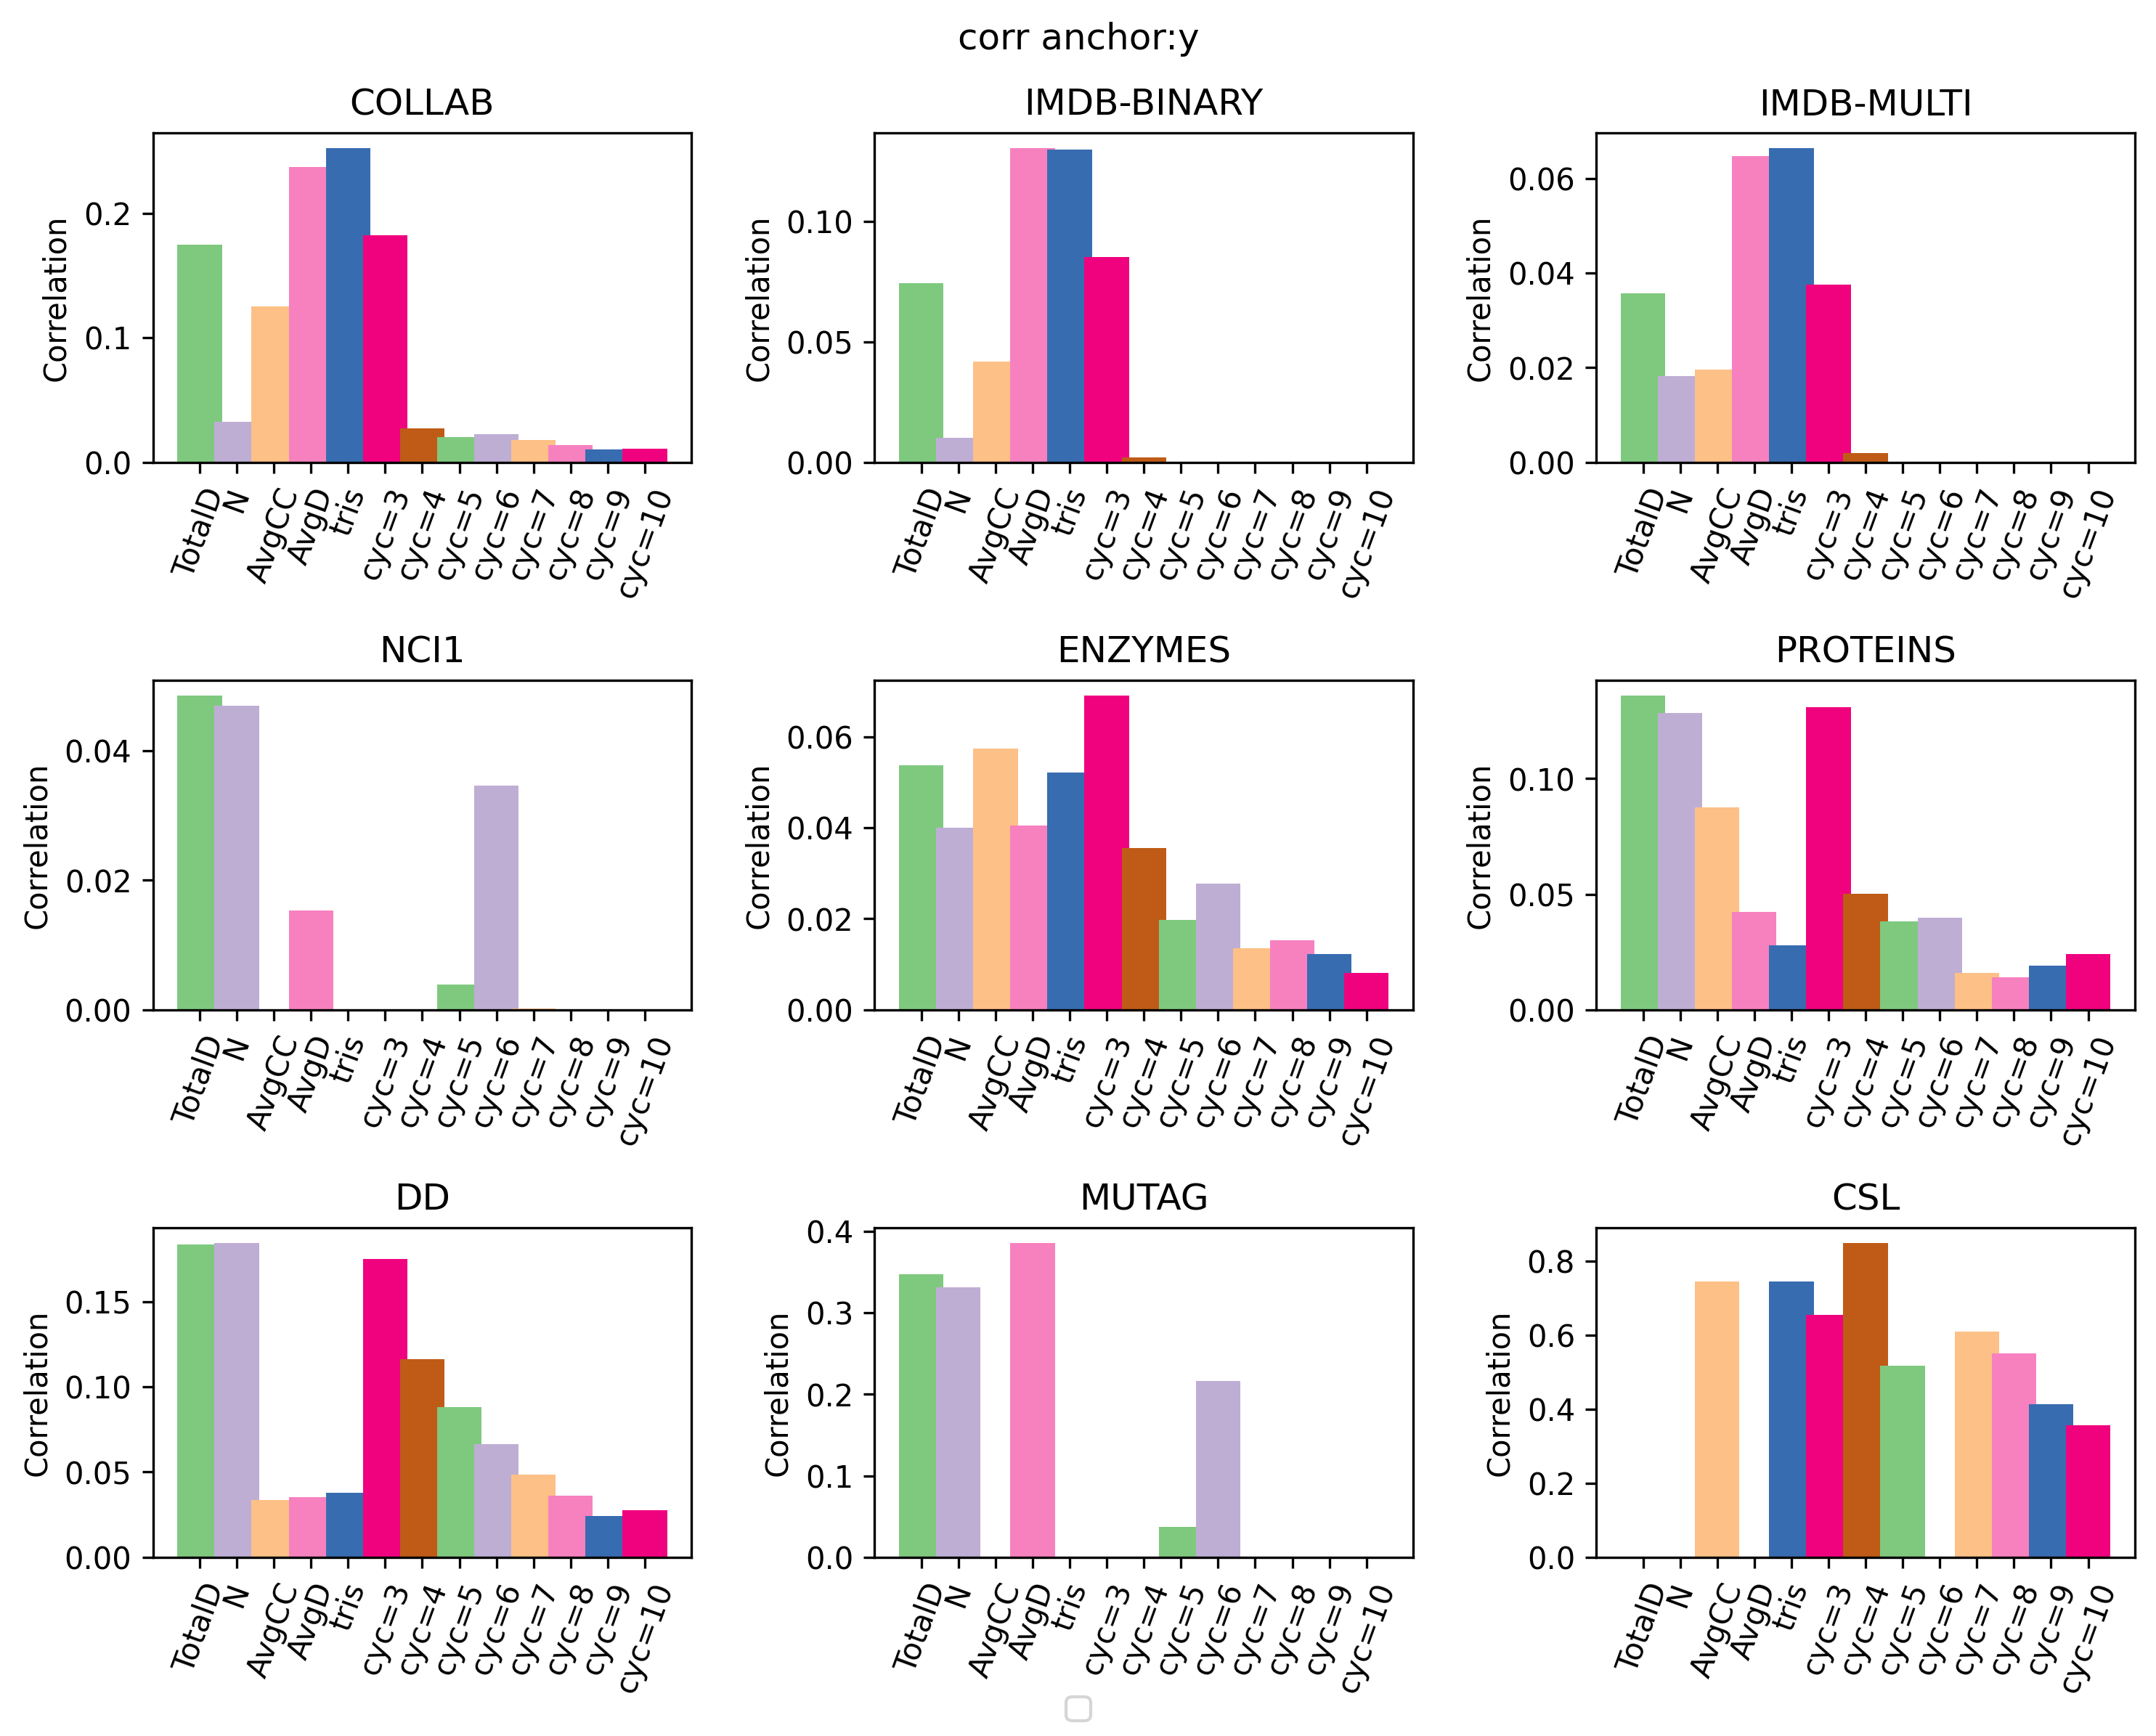

In [34]:
# tuple_label: ['TotalD', 'N', 'AvgCC', 'AvgD', 'tris', 'cyc<=4', 'cyc<=5', 'cyc<=6', 'cyc<=7', 'cyc<=8', 'cyc<=9', 'cyc<=10', 'y']

importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[0, 1, 2, 3,4,5,6,7,8,9, 10, 11, 12], anchor=-1)

In [ ]:
# tuple_label: ['TotalD', 'N', 'AvgCC', 'AvgD', 'tris', 'cyc<=4', 'cyc<=5', 'cyc<=6', 'cyc<=7', 'cyc<=8', 'cyc<=9', 'cyc<=10', 'y']

importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[0, 1, 2, 3,4,5,6,7,8,9, 10, 11, 12], anchor=-1,corrs_type='pearson')

In [ ]:
importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[3, 4,5,6,7,8, 9], anchor=1)

In [ ]:
x = range(7)
negative_data = [-1,0,-3,0,-6,-2,-8]
positive_data = [4,2,3,1,4,6,7,]

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(x, negative_data, width=1, color='r')
ax.bar(x, positive_data, width=1, color='b')

# plot train val loss, 2022.10.09

In [14]:
# TODO: load files.
import os


res_dir = './result_1009'
for root, dirs, files in os.walk(res_dir, topdown=True):
    print(dirs)
    for d in dirs:
        if 'pre' in d:
            continue
        sub_res_dir = os.path.join(root, d)
        for sub_root, sub_dirs, _ in os.walk(sub_res_dir,topdown=True):
            for conf_dir in sub_dirs:
                # for 
                with open(os.path.join(sub_root, conf_dir, 'experiment.log'), 'r') as f:
                    for line in f.readlines():
                        if 'TR loss' not in line:
                            continue
                        print(len(line.split()), line.split())
                        
            break
            
    break

['pre_results', 'GraphSAGE_IMDB-BINARY_assessment', 'GraphSAGE_REDDIT-BINARY_assessment', 'GraphSAGE_COLLAB_assessment']


FileNotFoundError: [Errno 2] No such file or directory: './result_1009/GraphSAGE_IMDB-BINARY_assessment/10_NESTED_CV/experiment.log'

[-2.        +0.j  2.        +0.j -1.61803399+0.j -1.61803399+0.j
 -0.61803399+0.j -0.61803399+0.j  0.61803399+0.j  0.61803399+0.j
  1.61803399+0.j  1.61803399+0.j]
[(-2+0j), (-1.6180339887498956+0j), (-1.6180339887498931+0j), (-0.618033988749895+0j), (-0.6180339887498947+0j), (0.6180339887498949+0j), (0.6180339887498955+0j), (1.6180339887498953+0j), (1.6180339887498965+0j), (2.000000000000001+0j)]


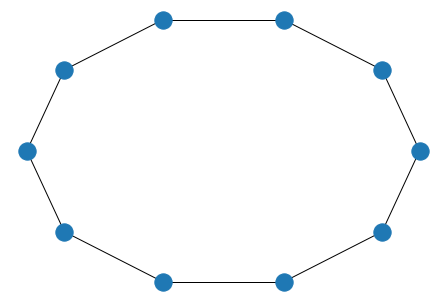

In [12]:
# plot spectrum of cycle graph:

c_g = nx.cycle_graph(10)
nx.draw_circular(c_g)
s = nx.adjacency_spectrum(c_g)
print(s)
s = sorted(s)
print(s)


